In [1]:
%matplotlib inline

In [2]:
# License: BSD
# Author: Sasank Chilamkurthy

from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True
plt.ion()

In [7]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((512, 512)),
        #transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
#     'val': transforms.Compose([
#         transforms.Resize((224,224)),
#         #transforms.CenterCrop(224),
#         transforms.ToTensor(),
#         transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
#     ]),
}

data_dir = '/media/uzair/5CE86067E860417E/plant-pathology-2020-fgvc7/organized_data/'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train']}
#                   for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=6,
                                             shuffle=True, num_workers=16)
                for x in ['train']}
#               for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) 
                for x in ['train']
#                  for x in ['train', 'val']
                }
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [8]:
my_test_data=torchvision.datasets.ImageFolder('/home/uzair/Downloads/data/plant-pathology-2020-fgvc7/test_images'
                                             , data_transforms['train'])

RuntimeError: Found 0 files in subfolders of: /home/uzair/Downloads/data/plant-pathology-2020-fgvc7/test_images
Supported extensions are: .jpg,.jpeg,.png,.ppm,.bmp,.pgm,.tif,.tiff,.webp

In [9]:
len(class_names)
print(len(image_datasets['train']))
# print(len(image_datasets['val']))
print(dataset_sizes['train'])
# print(dataset_sizes['val'])

2381
2381


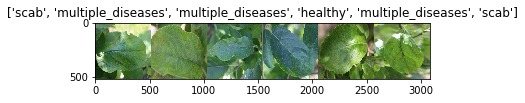

In [10]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [11]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    train_loss, val_loss, train_acc, val_acc = [], [], [], []
    
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train']:
#         for phase in ['train', 'val']:
            if phase == 'train':
                scheduler.step()
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            
            if phase == 'train':
                train_loss.append(epoch_loss)
                train_acc.append(epoch_acc)
            else:
                val_loss.append(epoch_loss)
                val_acc.append(epoch_acc)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            # deep copy the model
#             if phase == 'val' and epoch_acc > best_acc:
            if epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        #print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, [train_loss, train_acc, val_loss, val_acc]

In [12]:
def visualize_model(model, num_images=2):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['train']):
#         for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [13]:
model_ft = models.resnet50(pretrained=True)
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, 4)
# device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
# optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)
optimizer_ft = optim.Adam(model_ft.parameters(), lr=0.001)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [14]:
model_ft, info = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=45)
torch.save(model_ft.state_dict(), '/home/uzair/Downloads/data/recylce_material')

Epoch 0/44
----------


/home/uzair/anaconda3/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:82: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule.See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


train Loss: 1.0643 Acc: 0.5464
Epoch 1/44
----------
train Loss: 0.8159 Acc: 0.6913
Epoch 2/44
----------
train Loss: 0.7394 Acc: 0.7228
Epoch 3/44
----------
train Loss: 0.6433 Acc: 0.7631
Epoch 4/44
----------
train Loss: 0.6165 Acc: 0.7778
Epoch 5/44
----------
train Loss: 0.5678 Acc: 0.7967
Epoch 6/44
----------
train Loss: 0.3781 Acc: 0.8656
Epoch 7/44
----------
train Loss: 0.3583 Acc: 0.8811
Epoch 8/44
----------
train Loss: 0.2986 Acc: 0.8929
Epoch 9/44
----------
train Loss: 0.2883 Acc: 0.9047
Epoch 10/44
----------
train Loss: 0.2473 Acc: 0.9177
Epoch 11/44
----------
train Loss: 0.2473 Acc: 0.9122
Epoch 12/44
----------
train Loss: 0.2284 Acc: 0.9194
Epoch 13/44
----------
train Loss: 0.1893 Acc: 0.9320
Epoch 14/44
----------
train Loss: 0.1693 Acc: 0.9475
Epoch 15/44
----------
train Loss: 0.1633 Acc: 0.9437
Epoch 16/44
----------
train Loss: 0.1685 Acc: 0.9462
Epoch 17/44
----------
train Loss: 0.1514 Acc: 0.9458
Epoch 18/44
----------
train Loss: 0.1423 Acc: 0.9500
Epoch 

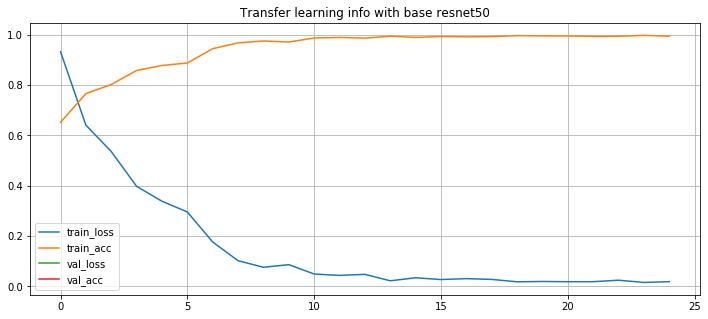

In [11]:
def show_info(info, basenet, full=True):
    train_loss, train_acc, val_loss, val_acc = info
    plt.figure(figsize=(12, 5))
    plt.plot(train_loss, label='train_loss')
    plt.plot(train_acc, label='train_acc')
    plt.plot(val_loss, label='val_loss')
    plt.plot(val_acc, label='val_acc')
    plt.legend()
    plt.grid()
    plt.title('Transfer learning info with base %s' % basenet)
    #plt.savefig('./results/%s_%d.png' % (basenet, full), )
show_info(info, 'resnet50')

In [38]:
torch.save(model_ft.state_dict(), '/home/uzair/Downloads/data/recylce_material512by512')

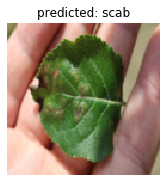

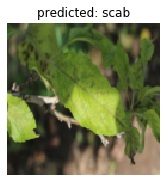

In [11]:
visualize_model(model_ft)

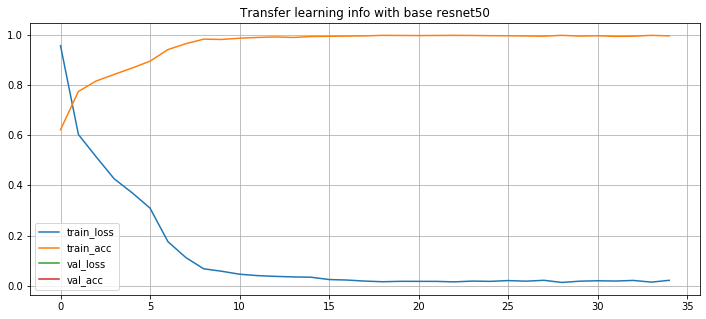

In [42]:
show_info(info, 'resnet50', 0)

## ConvNet as fixed feature extractor

In [28]:
torch.save(model_ft.state_dict(), '/home/uzair/Downloads/data/1recylce_material')

In [14]:
model_conv = torchvision.models.resnet18(pretrained=True)
for param in model_conv.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 2)

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

In [16]:
model_conv2, info2 = train_model(model_conv, criterion, optimizer_conv, exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------
train Loss: 1.4675 Acc: 0.1798
Epoch 1/24
----------
train Loss: 1.4676 Acc: 0.1785
Epoch 2/24
----------
train Loss: 1.4683 Acc: 0.1831
Epoch 3/24
----------
train Loss: 1.4684 Acc: 0.1848
Epoch 4/24
----------


KeyboardInterrupt: 

In [ ]:
show_info(info2, 'resnet18', 0)

In [ ]:
visualize_model(model_conv2)

plt.ioff()
plt.show()

In [11]:
# model_ft = model_ft
model_ft.load_state_dict(torch.load('/home/uzair/Downloads/data/recylce_material512by512'))
# model_ft.eval()

<All keys matched successfully>

In [3]:
#now only using code for pridiction 
'''
Define Transforms
Define Dataset Class
'''
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((128, 128)),
        #transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
#     'val': transforms.Compose([
#         transforms.Resize((224,224)),
#         #transforms.CenterCrop(224),
#         transforms.ToTensor(),
#         transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
#     ]),
}

class ppDataset(torch.utils.data.Dataset):
    def __init__(self, df, image_dir, return_labels=False, transforms=None):
        self.df = df
        self.image_dir = image_dir
        self.transforms = transforms
        self.return_labels = return_labels
        self.label_map = {'healthy':0, 'multiple_diseases':1, 'rust':2, 'scab':3}
        self.label_map_reverse = {v:k for k,v in self.label_map.items()}
        
    def __len__(self):
        return self.df.__len__()
    
    def __getitem__(self, idx):
        image_path = self.image_dir + self.df.loc[idx, 'image_id'] + '.jpg'
        image = Image.open(image_path).convert('RGB')
        
        if self.transforms:
            image = self.transforms(image)

        if self.return_labels:
            # label = torch.tensor(self.df.loc[idx, ['healthy', 'multiple_diseases', 'rust', 'scab']]).unsqueeze(1)
            label = torch.tensor(self.df.loc[idx, ['healthy', 'multiple_diseases', 'rust', 'scab']]).unsqueeze(-1)
            return image, label, self.label_map_reverse[label.squeeze(1).numpy().argmax()]
        else:
            return image

In [4]:
import pandas as pd
te_df = pd.read_csv('/home/uzair/Downloads/data/plant-pathology-2020-fgvc7/test.csv')

In [5]:
te_dataset = ppDataset(te_df, '/home/uzair/Downloads/data/plant-pathology-2020-fgvc7/test_images/', return_labels = False, transforms = data_transforms['train'])


In [6]:
#now making the data_loader for test dataset
test_loader=torch.utils.data.DataLoader(te_dataset, batch_size=16,
                                             shuffle=False, num_workers=16)

In [7]:
te_dataset

In [18]:
from PIL import Image

In [19]:
def get_all_predictions(loaded_data,my_network):
  my_network 
  final_stacked_result=None
  for batch in (loaded_data):
    with torch.set_grad_enabled(False):
         predictions=my_network(batch.to(device))
         test_prediction=predictions.data.cpu()
         if final_stacked_result is None:
            final_stacked_result=test_prediction.data.cpu()
         else:
             final_stacked_result=torch.cat((final_stacked_result,test_prediction.data.cpu()),dim=0)
  return final_stacked_result

#calling the function 
my_predictions=get_all_predictions(test_loader,model_ft)


In [20]:
my_predictions = torch.softmax(my_predictions, dim=1, dtype=float)
my_predictions.shape

torch.Size([1821, 4])

In [21]:
my_predictions.shape

torch.Size([1821, 4])

In [22]:
#reading_test_csv
my_test_csv1=pd.read_csv('/home/uzair/Downloads/data/plant-pathology-2020-fgvc7/test.csv')
my_test_csv1

,image_id
0,Test_0
1,Test_1
2,Test_2
3,Test_3
4,Test_4
5,Test_5
6,Test_6
7,Test_7
8,Test_8
9,Test_9


In [24]:
my_test_csv1['healthy']=np.array(my_predictions[:,0])
my_test_csv1['multiple_diseases']=np.array(my_predictions[:,1])
my_test_csv1['rust']=np.array(my_predictions[:,2])
my_test_csv1['scab']=np.array(my_predictions[:,3])

In [26]:
my_test_csv1

,image_id,healthy,multiple_diseases,rust,scab
0,Test_0,9.243853e-07,5.555455e-04,0.999443,7.629882e-07
1,Test_1,3.698172e-05,8.779310e-01,0.121987,4.461165e-05
2,Test_2,4.962352e-06,2.847890e-05,0.000003,9.999637e-01
3,Test_3,9.970944e-01,4.001876e-05,0.000061,2.804414e-03
4,Test_4,1.554126e-09,3.725971e-02,0.962740,2.225596e-08
5,Test_5,9.984550e-01,3.116869e-05,0.000134,1.380276e-03
6,Test_6,9.997728e-01,4.894445e-06,0.000026,1.959526e-04
7,Test_7,1.658546e-06,1.208318e-05,0.000002,9.999846e-01
8,Test_8,5.526380e-05,3.202622e-03,0.000006,9.967361e-01
9,Test_9,3.207231e-08,5.223497e-05,0.999948,2.312566e-08


In [27]:
my_test_csv1.to_csv('predicted_test_csv.csv',index=False)

In [ ]:
model_ft=model_ft.to("cpu")

In [19]:
batch=batch.unsqueeze(dim=0)

In [31]:
pred=model_ft(batch.to("cpu"))

In [32]:
pred.shape

torch.Size([16, 4])